In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
def input_reader(input_file):
    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layers = int(lines[2])
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
        return T_eff, gravity, num_layers, np.array(input_data)

T_eff, gravity, num_layers, input_data = input_reader("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
input_data = input_data[input_data[:,1].argsort()]
# print(input_data)
# print(input_data.shape)


In [4]:
def pvap_nh3(t):
    pvap = math.exp(-86596.0 / t**2 - 2161.0 / t + 10.53)
    # pvap *= 10**6  # convert from bars to dyne/cm^2
    return pvap

R_GAS = 8.314462618e7
PI = math.pi


In [5]:
def cloud_base(data):
    for i in range(len(data)-1, -1, -1):
        T, P = data[i]
        pvap = pvap_nh3(T)
        qt = 3*(10**(-5))*17/2.2
        qv = (17/2.2)*pvap/P
        if qt > qv:
            q_below = qt
            print(T, P, np.log10(qt-qv))
            return i, q_below

base, q_below = cloud_base(input_data)
print(base, q_below)
print(input_data[base])

127.2 0.39811 -4.056696272290015
51 0.0002318181818181818
[127.2       0.39811]


In [7]:
def read_voyager(teff, grav, nzp1, t_edge, p_edge):
    """
    Calculate atmospheric profiles for Galileo probe sounding.
    Arguments:
        teff: effective temperature (K)
        grav: gravitational acceleration (cm/s^2)
        nzp1: number of layer edges
        t_edge: array of temperatures at layer edges (K), length nzp1
        p_edge: array of pressures at layer edges (bars), length nzp1
    Returns:
        nz: number of layers
        z: altitudes at layer midpoints (cm), length nz
        z_edge: altitudes at layer edges (cm), length nzp1
        p: pressures at layer midpoints (bars), length nz
        t: temperatures at layer midpoints (K), length nz
        chf: convective heat flux (erg/cm^2/s), length nz
        mixl: mixing length (cm), length nz
    """
    r_atmos = 8.3143e7 / 2.2
    STEFBOLTZ = 5.67051e-5

    
    p_edge = np.array(p_edge)
    t_edge = np.array(t_edge)
    nz = nzp1 - 1

    z = np.zeros(nz)
    z_edge = np.zeros(nzp1)
    p = np.zeros(nz)
    t = np.zeros(nz)
    chf = np.zeros(nz)
    mixl = np.zeros(nz)

    z_edge[nz] = 0.0

    for iz in range(nz - 1, -1, -1):
        itop = iz
        ibot = iz + 1
        dlnp = np.log(p_edge[ibot] / p_edge[itop])
        p[iz] = 0.5 * (p_edge[itop] + p_edge[ibot])
        scale_h = r_atmos * t_edge[ibot] / grav
        dz_layer = scale_h * dlnp
        z_edge[iz] = z_edge[ibot] + dz_layer
        dtdz = (t_edge[itop] - t_edge[ibot]) / dz_layer
        dz_pmid = scale_h * np.log(p_edge[ibot] / p[iz])
        z[iz] = z_edge[ibot] + dz_pmid
        t[iz] = t_edge[ibot] + dtdz * dz_pmid
        lapse_ratio = (t_edge[ibot] - t_edge[itop]) / dlnp / (2. / 7. * t[iz])
        mixl[iz] = max(0.1, lapse_ratio) * scale_h

    for iz in range(nz):
        chf[iz] = STEFBOLTZ * teff ** 4

    return nz, z, z_edge, p, t, chf, mixl
read_voyager
nz, z, z_edge, p, t, chf, mixl = read_voyager(T_eff, gravity, num_layers, input_data[:,0], input_data[:,1])

In [ ]:
def layer(teff, grav, nzp1, nsub, t_edge, p_edge):
    """
    Calculate atmospheric profiles for Galileo probe sounding.
    Arguments:
        teff: effective temperature (K)
        grav: gravitational acceleration (cm/s^2)
        nzp1: number of layer edges
        nsub: number of sublayers
        t_edge: array of temperatures at layer edges (K), length nzp1
        p_edge: array of pressures at layer edges (bars), length nzp1
    Returns:
        nz: number of layers
        nzsub: total number of sublayers
        z: altitudes at layer midpoints (cm), length nzsub
        z_edge: altitudes at layer edges (cm), length nzsub+1
        p: pressures at layer midpoints (bars), length nzsub
        t: temperatures at layer midpoints (K), length nzsub
        chf: convective heat flux (erg/cm^2/s), length nzsub
        mixl: mixing length (cm), length nzsub
    """
    r_atmos = 8.3143e7 / 2.2
    STEFBOLTZ = 5.67051e-5

    
    p_edge = np.array(p_edge)
    t_edge = np.array(t_edge)
    nz = nzp1 - 1
    nzsub = nz*nsub

    z = np.zeros(nzsub)
    z_edge = np.zeros(nzsub+1)
    p = np.zeros(nzsub)
    t = np.zeros(nzsub)
    chf = np.zeros(nzsub)
    mixl = np.zeros(nzsub)

    z_edge[nzsub] = 0.0

    for iz in range(nz - 1, -1, -1):
        itop = iz
        ibot = iz + 1
        p_top, p_bot = p_edge[itop], p_edge[ibot]
        t_top, t_bot = t_edge[itop], t_edge[ibot]
        dp_layer = p_bot - p_top
        dlnp = np.log(p_bot/p_top)
        dtdlnp = ( t_top - t_bot ) / dlnp
        dp_sub = dp_layer/nsub
        scale_h = r_atmos * t_edge[ibot] / grav
        p_sub_bot = p_bot
        z_edge_sub_bot = z_edge[ibot]
        t_sub_bot = t_bot

        for i in range(nsub-1, -1, -1):
            p_sub_top = p_sub_bot - dp_sub
            t_sub_top = t_sub_bot + np.log(p_sub_bot/p_sub_top)*dtdlnp
            dz_sub = scale_h * np.log(p_sub_bot/p_sub_top)
            p_sub = 0.5*(p_sub_bot+p_sub_top)
            t_sub = t_sub_bot + np.log(p_sub_bot/p_sub)*dtdlnp
            p[iz*nsub+i] = p_sub
            t[iz*nsub+i] = t_sub
            z_edge_sub_top = z_edge_sub_bot + dz_sub
            z_edge[iz*nsub+i] = z_edge_sub_top
            z[iz*nsub+i] = z_edge_sub_bot + scale_h*np.log(p_sub_bot/p_sub)
            lapse_ratio = (t_sub_bot - t_sub_top)/ np.log(p_sub_bot/p_sub_top) / (2/7 * t_sub)
            mixl[iz*nsub+i] = max(0.1, lapse_ratio) * scale_h

            p_sub_bot = p_sub_top
            t_sub_bot = t_sub_top
            z_edge_sub_bot = z_edge_sub_top

    for iz in range(nz):
        chf[iz] = STEFBOLTZ * teff ** 4

    return nz, nzsub, z, z_edge, p, t, chf, mixl

nz, nzsub, z, z_edge, p, t, chf, mixl = layer(T_eff, gravity, num_layers, 10, input_data[:,0], input_data[:,1])


In [8]:
## Analytical Method

f_rain = 10
output = []
for i in range(nz-1, -1, -1):
    if p[i] <= 0.4224:
        if len(output) == 0:
            T_mid, P_mid, z_mid = t[i], p[i], z[i]
            pvap = pvap_nh3(T_mid)
            rho_atmos = P_mid/(R_GAS/2.2 * T_mid)
            qv = pvap / ( (R_GAS/17) * T_mid ) / rho_atmos
            qt = 3*(10**(-5))*(17/2.2)
            output.append([T_mid, P_mid, qv, qt, qt-qv, z_mid])
        else:
            T_mid_prev, P_mid_prev, qv_prev, qt_prev, qc_prev, z_mid_prev = output[-1]
            T_mid, P_mid, z_mid = t[i], p[i], z[i]
            pvap = pvap_nh3(T_mid)
            rho_atmos = P_mid/(R_GAS/2.2 * T_mid)
            qv = pvap / ( (R_GAS/17) * T_mid ) / rho_atmos
            qt = qv + (qc_prev)*np.exp(-(z_mid-z_mid_prev)*f_rain/mixl[i])
            output.append([T_mid, P_mid, qv, qt, qt-qv, z_mid])
output = np.array(output)

In [ ]:
## Numerical method

f_rain = 10
output = []
for i in range(nz-1, -1, -1): # nz for read_voyager and nzsub for layer
    if p[i] <= 0.4224:
        if len(output) == 0:
            T_mid, P_mid, z_mid = t[i], p[i], z[i]
            pvap = pvap_nh3(T_mid)
            rho_atmos = P_mid/(R_GAS/2.2 * T_mid)
            qv = pvap / ((R_GAS/17)*T_mid) / rho_atmos
            qt = 3*(10**(-5))*(17/2.2)
            output.append([T_mid, P_mid, qv, qt, qt-qv, z_mid])
        else:
            T_mid_prev, P_mid_prev, qv_prev, qt_prev, qc_prev, z_mid_prev = output[-1]
            T_mid, P_mid, z_mid = t[i], p[i], z[i]
            pvap = pvap_nh3(T_mid)
            rho_atmos = P_mid/(R_GAS/2.2 * T_mid)
            qv = pvap / ( (R_GAS/17) * T_mid ) / rho_atmos
            dqt = - f_rain * qc_prev * (z_mid - z_mid_prev) / mixl[i]
            qt = qt_prev + dqt
            output.append([T_mid, P_mid, qv, qt, qt-qv, z_mid])
output = np.array(output)

In [9]:
# Read voyager_frain1_sig2.out
file = "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out"
voyager = []
with open(file, "r") as f:
    lines = f.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        voyager.append([float(x.replace("E", "e")) for x in parts])
voyager = np.array(voyager)

print(voyager[:,4].shape)

(312,)


/tmp/ipykernel_6636/1224275322.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), P, marker='o')
/tmp/ipykernel_6636/1224275322.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')


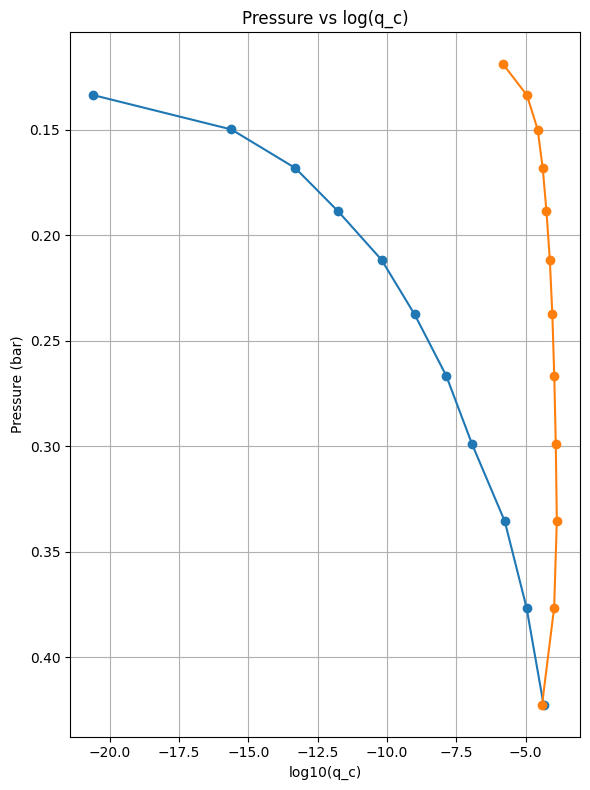

In [10]:
qc = output[:,4]
P = output[:,1]
plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), P, marker='o')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
print(qc)

[4.47868903e-05 1.08796715e-05 1.78084330e-06 1.18375157e-07
 1.37572138e-08 1.00024985e-09 6.45935061e-11 1.75054595e-12
 4.95628183e-14 2.47226894e-16 2.54109884e-21 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [12]:
print(np.log10(voyager[:,4])
      )

[       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf -5.80465394 -4.95039439
 -4.56114134 -4.38007229 -4.24366823 -4.12337808 -4.03273291 -3.96377046
 -3.90798153 -3.87095494 -3.9677843  -4.40296334        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf   

/tmp/ipykernel_6636/408587861.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(voyager[:,4])
